In [1]:
import os
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import febrisk
lib_path = os.path.join(os.path.abspath('.'), '..\\..')
sys.path.append(lib_path)
from febrisk.dist_fit import NormalFitter, TFitter
from febrisk.simulation import CopulaSimulator
from febrisk.risk import VaR, expected_shortfall
from febrisk.performance import cal_arith_return

sns.set_style("darkgrid")

# Problem 1:
Use the data in problem1.csv. Fit a Normal Distribution and a Generalized T distribution to this data.
Calculate the VaR and ES for both fitted distributions.
Overlay the graphs the distribution PDFs, VaR, and ES values. What do you notice? Explain the
differences.

In [50]:
p1_data = pd.read_csv("problem1.csv").values.T

normal_fitter = NormalFitter()
normal_fitter.fit(x=p1_data, x0=(np.mean(p1_data), np.std(p1_data)))
norm_dist = normal_fitter.fitted_dist

t_fitter = TFitter()
t_fitter.fit(x=p1_data)
t_dist = t_fitter.fitted_dist

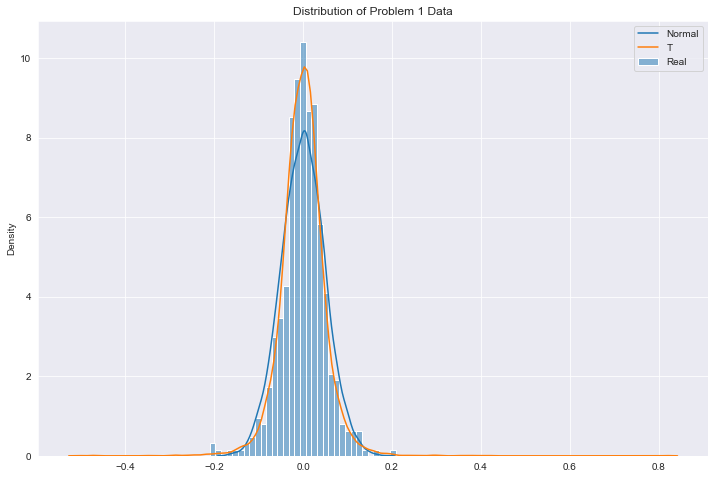

In [51]:
nsample = 10000
norm_sim_data = norm_dist.rvs(nsample)
t_sim_data = t_dist.rvs(nsample)

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(p1_data.T, stat='density', ax=ax, label='Real')
sns.kdeplot(norm_sim_data, ax=ax, label='Normal')
sns.kdeplot(t_sim_data, ax=ax, label='T')
ax.set_title("Distribution of Problem 1 Data")
ax.legend()

In [52]:
var_norm = VaR(norm_sim_data, mean=np.mean(norm_sim_data))
var_t = VaR(t_sim_data, mean=np.mean(norm_sim_data))
print("VaR under Normal Distribution: ", var_norm)
print("VaR under T Distribution: ", var_t)

es_norm = expected_shortfall(norm_sim_data)
es_t = expected_shortfall(t_sim_data)
print("Expected Shortfall under Normal Distribution:", es_norm)
print("Expected Shortfall under T Distribution:", es_t)

VaR under Normal Distribution:  0.08243120577466873
VaR under T Distribution:  0.07618620380954716
Expected Shortfall under Normal Distribution: 0.10302828258208516
Expected Shortfall under T Distribution: 0.1143986594549322


# Problem 3: 
Use your repository from #2.
Using Portfolio.csv and DailyPrices.csv. Assume the expected return on all stocks is 0.
This file contains the stock holdings of 3 portfolios. You own each of these portfolios.
Fit a Generalized T model to each stock and calculate the VaR and ES of each portfolio as well as your
total VaR and ES. Compare the results from this to your VaR form Problem 3 from Week 4.

In [2]:
prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"], index_col=[0])
rets = cal_arith_return(prices)

In [4]:
expected_return_eq_0 = ({"type": "eq", "fun": lambda x: x[0]},)
fitters = [TFitter(expected_return_eq_0)
           for _ in range(rets.shape[1])]

cpl_simulator = CopulaSimulator()
cpl_simulator.fit(rets.values.T, fitters)
sim_rets = pd.DataFrame(columns=rets.columns, data=cpl_simulator.simulate(10000).T)

C:\python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:1945: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


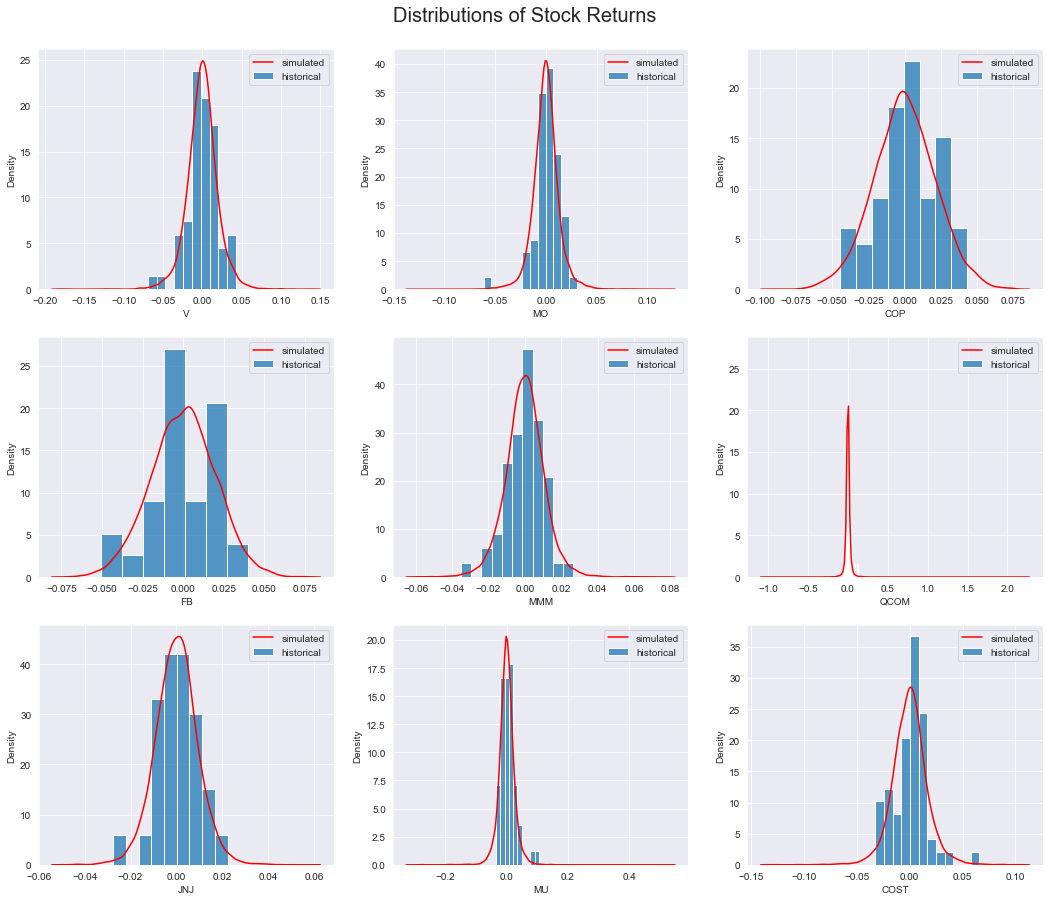

In [5]:
import random

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
stocks = random.sample(rets.columns.tolist(), 9)

fig.suptitle("Distributions of Stock Returns", fontsize=20, y=0.92)
for i, stock in enumerate(stocks):
    ax = axes[i//3][i%3]
    sns.histplot(rets[stock], ax=ax, stat='density', label='historical')
    sns.kdeplot(sim_rets[stock], ax=ax, color='r', label='simulated')
    ax.legend()

VaR of Portfolio A: 6263.60
ES of Portfolio A: -356350.74
Historical VaR of Portfolio A: 5329.25
Historical ES of Portfolio A: -356910.03

VaR of Portfolio B: 4895.11
ES of Portfolio B: -320141.79
Historical VaR of Portfolio B: 5579.83
Historical ES of Portfolio B: -319539.07

VaR of Portfolio C: 3924.81
ES of Portfolio C: -321386.21
Historical VaR of Portfolio C: 3320.22
Historical ES of Portfolio C: -321846.35

VaR of Portfolio D: 14491.18
ES of Portfolio D: -998622.00
Historical VaR of Portfolio D: 12593.87
Historical ES of Portfolio D: -998295.45



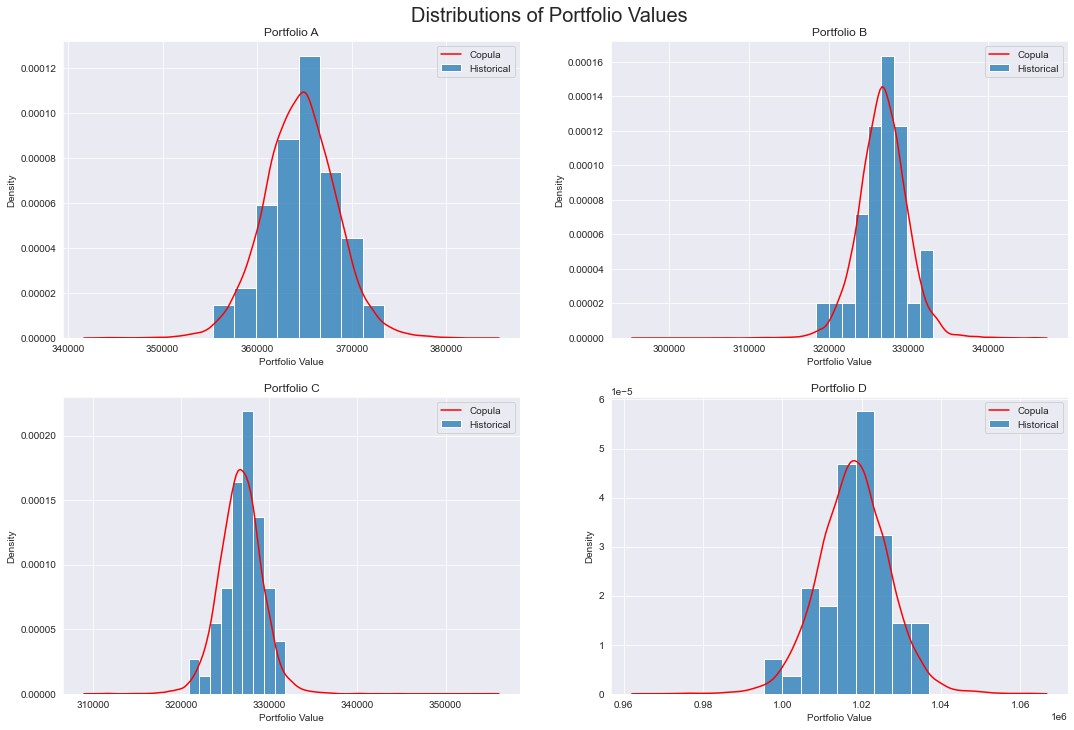

In [7]:
# load portfolio 
portfolios = pd.read_csv("Portfolio.csv")

# calculate total holdings on each asset, consider it as portfolio D
total_holdings = portfolios.groupby('Stock').sum('Holding')
total_holdings['Portfolio'] = 'D'
total_holdings = total_holdings.reset_index()
portfolios = pd.concat([portfolios, total_holdings], axis=0)

current_prices = pd.DataFrame({"Price":prices.iloc[-1]})

i = 0
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Distributions of Portfolio Values", fontsize=20, y=0.92)
for pfl, pfl_df in portfolios.groupby('Portfolio'):
    # include current price of each asset
    portfolio = pfl_df.set_index('Stock')
    portfolio = portfolio.join(current_prices.loc[portfolio.index])

    # calculate the value of each asset
    portfolio['Value'] = portfolio['Holding'] * portfolio['Price']

    # simulate future prices and values
    sim_prices = (1 + sim_rets[portfolio.index]) * portfolio['Price'].T
    sim_values = sim_prices @ portfolio['Holding']

    # compare to historical return data
    sim_prices_hist = (1 + rets[portfolio.index]) * portfolio['Price'].T
    sim_values_hist = sim_prices_hist @ portfolio['Holding']
    
    ax = axes[i//2][i%2]
    sns.kdeplot(sim_values, ax=ax, color='r', label='Copula')
    sns.histplot(sim_values_hist, ax=ax, stat='density', label='Historical')
    ax.set_title(f"Portfolio {pfl}")
    ax.set_xlabel("Portfolio Value")
    ax.legend()

    # print results
    present_value = portfolio['Value'].sum()
    print(f"VaR of Portfolio {pfl}: {VaR(sim_values, present_value):.2f}")
    print(f"ES of Portfolio {pfl}: {expected_shortfall(sim_values):.2f}")
    print(f"Historical VaR of Portfolio {pfl}: {VaR(sim_values_hist, present_value):.2f}")
    print(f"Historical ES of Portfolio {pfl}: {expected_shortfall(sim_values_hist):.2f}")
    print()

    i += 1
